In [26]:
!pip install onedrivedownloader
from onedrivedownloader import download

url = 'https://universidadfv-my.sharepoint.com/:u:/g/personal/alberto_desantos_ufv_es/EVwGsj7cAV5EvjJPWcqJ1lUBPhP5mKEkv-6fzmAM4jJSkw?e=pjOhYH'

download(url = url, filename = 'archivo.zip', unzip=True, force_download=True, clean=True)

100%|██████████| 34.5M/34.5M [00:02<00:00, 13.2MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 200/200 [00:00<00:00, 154401.03it/s]


''

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Conv2DTranspose,Activation,concatenate,Input
from tensorflow.keras import Sequential,Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt

In [29]:
def conv_block(input,filters):
    x = Conv2D(filters,3,padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input,filters):

    x = conv_block(input,filters)
    p = MaxPooling2D((2,2))(x)
    return x,p

def decoder_block(input,skip,filters):

    x = Conv2DTranspose(filters,2,strides=2,padding="same")(input)
    x = concatenate([x,skip])
    x = conv_block(x,filters)
    return x


In [30]:
def build_model_2_layers():
    # Entrada del modelo
    input = Input(shape=(512, 512, 3))

    # Encoder con 2 capas
    x1, p1 = encoder_block(input, 64)   # Primera capa del encoder
    x2, p2 = encoder_block(p1, 128)     # Segunda capa del encoder

    # Bottleneck (parte intermedia)
    a1 = conv_block(p2, 256)

    # Decoder con 2 capas
    d1 = decoder_block(a1, x2, 128)     # Primera capa del decoder
    d2 = decoder_block(d1, x1, 64)      # Segunda capa del decoder

    # Capa de salida
    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d2)

    # Definir el modelo
    model = Model(input, output)
    return model


In [31]:
def load_data(path,img_size):
    images = []
    masks = []
    for img_files,mask_files in zip(os.listdir(path+"/image"),os.listdir(path+"/mask")):
        img_path = os.path.join(path+"/image",img_files)
        mask_path = os.path.join(path+"/mask",mask_files)

        img = load_img(img_path,target_size=img_size)
        mask = load_img(mask_path,target_size=img_size,color_mode="grayscale")

        img = img_to_array(img)/255.0
        mask = img_to_array(mask)/255.0

        images.append(img)
        masks.append(mask)
    return np.array(images),np.array(masks)

In [32]:
def augment_image(image, mask):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, mask

In [33]:
x_train,y_train = load_data("/content/Data/train",img_size=(512,512))
x_test,y_test = load_data("/content/Data/test",img_size=(512,512))
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((80, 512, 512, 3), (80, 512, 512, 1), (20, 512, 512, 3), (20, 512, 512, 1))

In [34]:
def tf_dataset(x,y,batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=8)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(x_train,y_train,batch_size=8)
test_dataset = tf_dataset(x_test,y_test,batch_size=8)

In [35]:
model = build_model_2_layers()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [36]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss',
                             save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min',
                               verbose=1, restore_best_weights=True)

In [37]:
history = model.fit(train_dataset,
                    epochs=100,
                    batch_size=8,
                    validation_data=test_dataset,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5950 - loss: 0.6884
Epoch 1: val_loss improved from inf to 0.70614, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6080 - loss: 0.6742 - val_accuracy: 0.6533 - val_loss: 0.7061
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8723 - loss: 0.3144
Epoch 2: val_loss improved from 0.70614 to 0.60695, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8726 - loss: 0.3133 - val_accuracy: 0.8436 - val_loss: 0.6070
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8725 - loss: 0.2894
Epoch 3: val_loss did not improve from 0.60695
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8729 - loss: 0.2887 - val_accuracy: 0.5915 - val_loss: 0.6830
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8742 - loss: 0.2806
Epoch 4: val_loss improved from 0.60695 to 0.53878, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Metrics Summary:
Average IoU: 0.5764
IoU Standard Deviation: 0.0473
Average F1 Score: 0.7301
F1 Score Standard Deviation: 0.0390
Average Dice Loss: 0.2699
Dice Loss Standard Deviation: 0.0390
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━

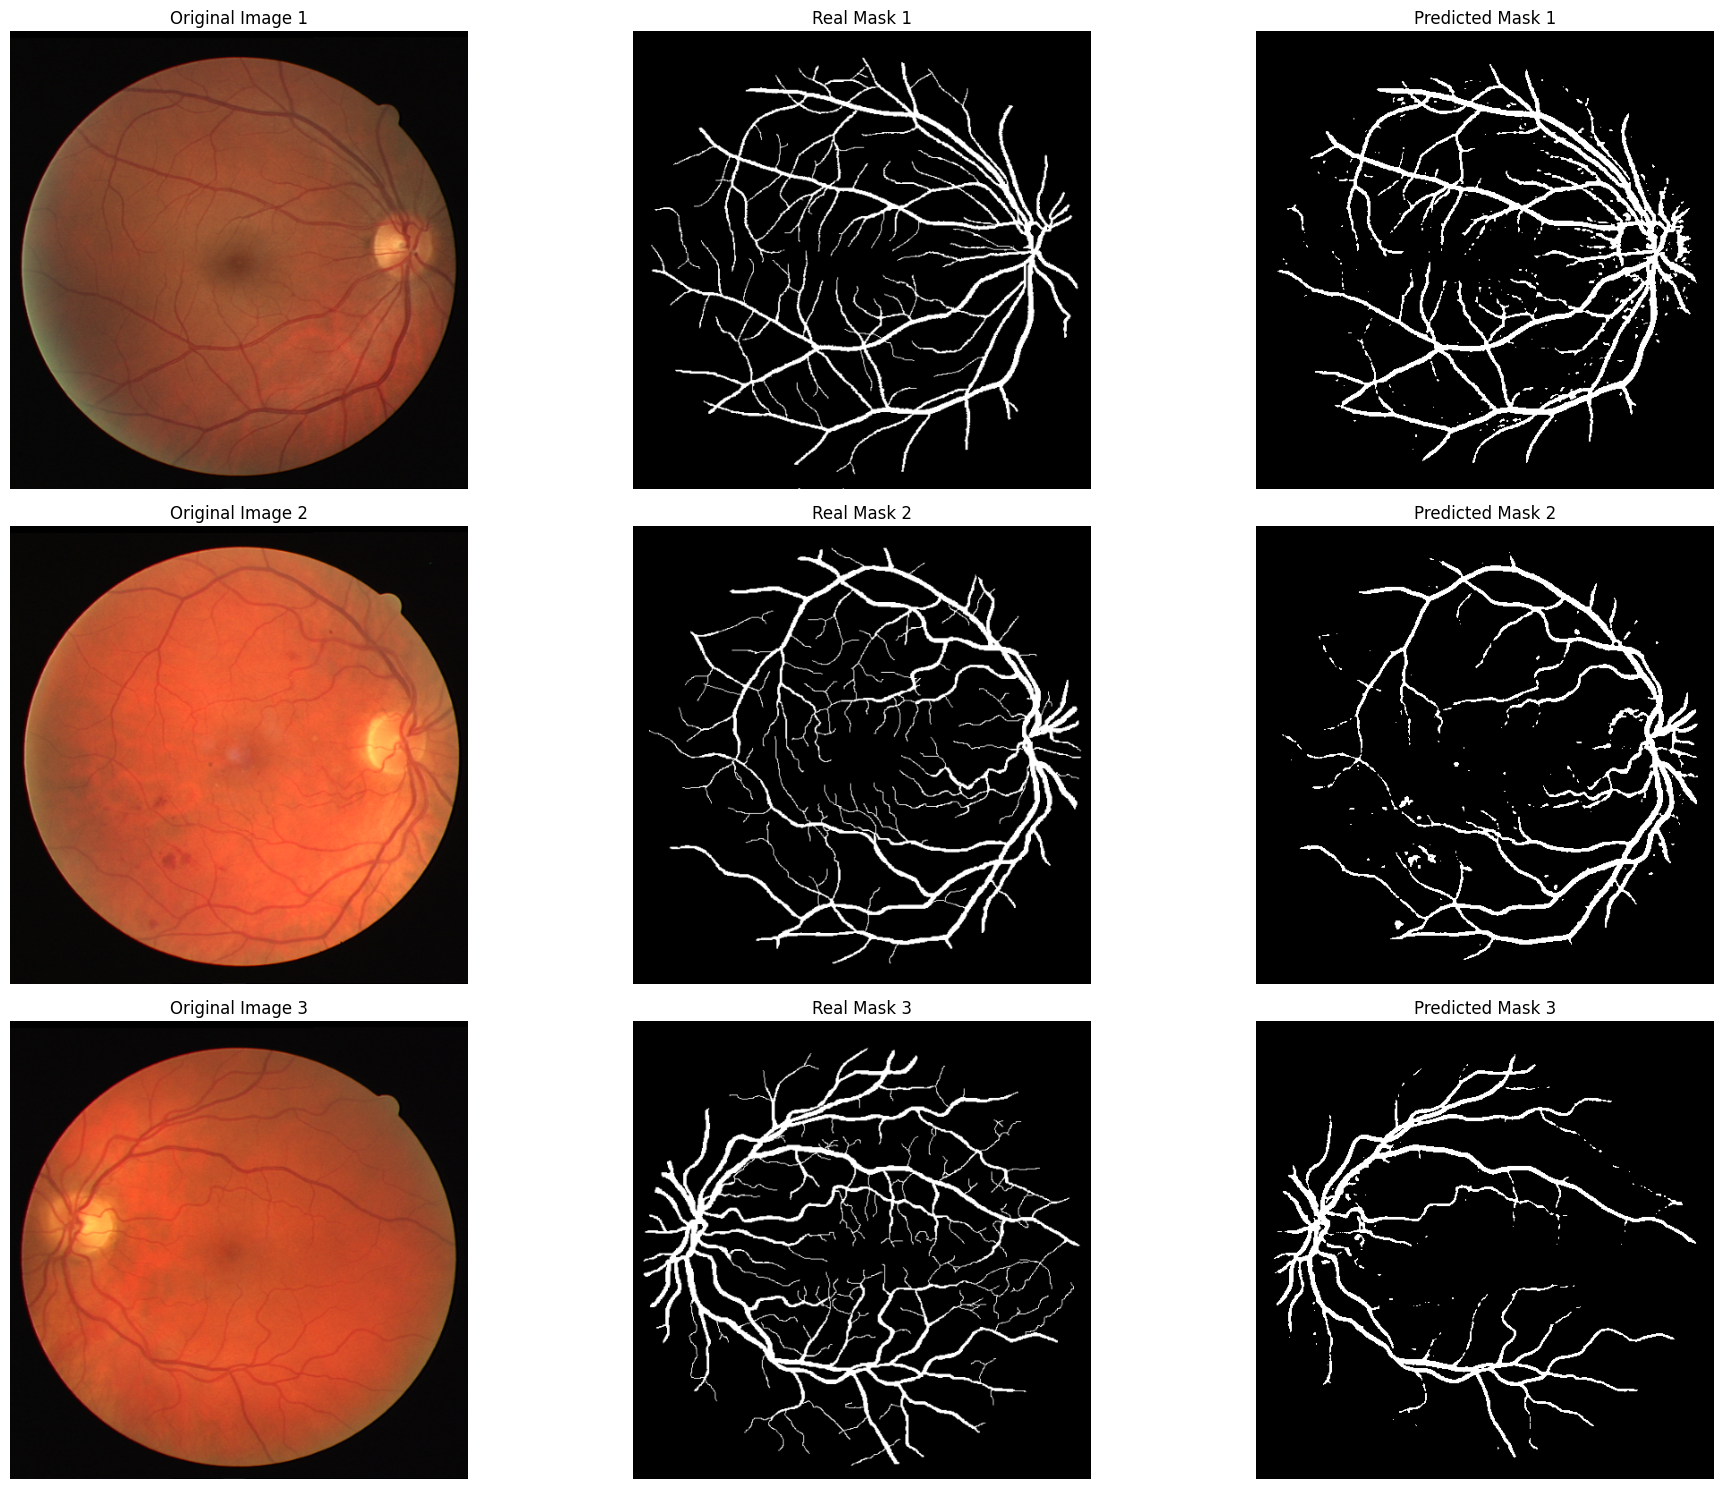

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice

def calculate_metrics(y_true, y_pred, threshold=0.5):
    # Ensure binary targets
    y_true_binary = (y_true > threshold).astype(np.int32)
    y_pred_binary = (y_pred > threshold).astype(np.int32)

    # IoU
    intersection = np.sum(y_true_binary * y_pred_binary)
    union = np.sum(y_true_binary) + np.sum(y_pred_binary) - intersection
    iou = intersection / (union + 1e-6)

    # F1 Score
    y_true_flat = y_true_binary.flatten()
    y_pred_flat = y_pred_binary.flatten()
    f1 = f1_score(y_true_flat, y_pred_flat)

    # Dice Loss
    dice = dice_loss(y_true_binary, y_pred_binary)

    return iou, f1, dice.numpy()

# Analyze all images in x_test
metrics = []

for index in range(len(x_test)):
    # Get image and its corresponding mask
    image = x_test[index]
    mask = y_test[index]

    # Predict mask using the trained model
    predicted_mask = model.predict(image[np.newaxis, ...])[0]
    predicted_mask = (predicted_mask > 0.2).astype(np.float32)

    # Calculate metrics
    iou, f1, dice_loss_value = calculate_metrics(mask, predicted_mask)
    metrics.append((iou, f1, dice_loss_value))

# Convert metrics to numpy array for easier calculations
metrics = np.array(metrics)

# Print metrics statistics
print("Metrics Summary:")
print(f"Average IoU: {np.mean(metrics[:, 0]):.4f}")
print(f"IoU Standard Deviation: {np.std(metrics[:, 0]):.4f}")
print(f"Average F1 Score: {np.mean(metrics[:, 1]):.4f}")
print(f"F1 Score Standard Deviation: {np.std(metrics[:, 1]):.4f}")
print(f"Average Dice Loss: {np.mean(metrics[:, 2]):.4f}")
print(f"Dice Loss Standard Deviation: {np.std(metrics[:, 2]):.4f}")

# Visualization of first three images with masks
plt.figure(figsize=(20, 15))

for i in range(3):
    # Original image
    plt.subplot(3, 3, i*3+1)
    plt.imshow(x_test[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Real mask
    plt.subplot(3, 3, i*3+2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title(f"Real Mask {i+1}")
    plt.axis('off')

    # Predicted mask
    predicted_mask = model.predict(x_test[i][np.newaxis, ...])[0]
    predicted_mask = (predicted_mask > 0.2).astype(np.float32)

    plt.subplot(3, 3, i*3+3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title(f"Predicted Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()
